# NLP Analysis from a stock forum - MoneyControl
### <span style="color:red">This is just a simple project without considering various real-time market conditions and factors. This analysis should no way be used for personal investments.</span>


## Scraping Data from a Stock Forum (MoneyControl) where general discussions about various stocks happen.
### Analysis such as Frequency and Sentiment will be calculated on the data scraped from MoneyControl. Such analysis can be helpful while determining which stock to invest
### *1). Lets start Scraping !!*

In [5]:
import pandas as pd
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By
#WebDriver is a browser automation framework that works with open source APIs.
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
#headless means running chrome with chrome.exe
chrome_options.add_argument('--headless')

chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [6]:
driver = webdriver.Chrome(options=chrome_options)

# forum link from where we are gonna scrape data
driver.get("https://mmb.moneycontrol.com/forum-topics/stocks-1.html")

#Handling Popups
if len(driver.window_handles) > 1:
    # Switch to the new window
    driver.switch_to.window(driver.window_handles[1])
else:
    print("There is no second window to switch to.")


There is no second window to switch to.


In [7]:
# To truncate the output generated
%%capture captured_output

import pandas as pd
import time

# Initialize an empty DataFrame to store comments
comments = pd.DataFrame(columns=['Stock', 'Date', 'Comments'])


# Function to remove blockquotes from an element
def remove_blockquotes(element):
    try:
        while True:
            try:
                blockquotes = element.find_elements(By.TAG_NAME, "blockquote")
                for blockquote in blockquotes:
                    driver.execute_script("arguments[0].remove();", blockquote)
            except StaleElementReferenceException:
                # Handle the stale element exception (e.g., log a message)
                print("Stale blockquote element encountered. Continuing removal.")
                continue
            else:
                # No exception occurred, exit the loop
                break
    except Exception as e:
        # Handle other exceptions that may occur during removal
        print(f"An error occurred: {str(e)}")

i = 0
# Loop through pages and scrape comments
for page_number in range(435,1,-1):
        
        # Construct the URL for the current page
    # current_page_url = val + '/p'+str(page_number)
    # driver.get(current_page_url)
    
    start_time = time.time()

    
        # Locate Comment elements on the current page
    comment_elements = driver.find_elements(By.CLASS_NAME, "postItem_container__1QMN1")

    # Loop through comments on the current page
    for element in comment_elements:

        try:
            # Remove blockquotes from the comment
            remove_blockquotes(element)

            # Extract comment details
            stock = element.find_element(By.CLASS_NAME, "postItem_heading__2odZU").text
            date = element.find_element(By.CLASS_NAME, "postItem_price__1yXow").text
            comment = element.find_element(By.CLASS_NAME, "postItem_text_paragraph__3XhZQ").text

            # Append the comment to the DataFrame
            comments.loc[len(comments)] = [stock, date, comment]
            
            i += 1
        except StaleElementReferenceException:
            # Handle the exception (e.g., log a message or continue to the next element)
            print("Stale element encountered. Skipping.")
            # Remove blockquotes from the comment
            remove_blockquotes(element)

            # Extract comment details
            stock = element.find_element(By.CLASS_NAME, "postItem_heading__2odZU").text
            date = element.find_element(By.CLASS_NAME, "postItem_price__1yXow").text
            comment = element.find_element(By.CLASS_NAME, "postItem_text_paragraph__3XhZQ").text

            # Append the comment to the DataFrame
            comments.loc[len(comments)] = [stock, date, comment] 
            
            i += 1
        #time.sleep(0.5)    
        if i >= 5000:
            break
    end_time = time.time() 
    elapsed_time = end_time - start_time
    print(f"Elapsed time for page {page_number}: {elapsed_time} seconds")
    #time.sleep(1)
    if i >= 5000:
        break
            
driver.quit()            


In [6]:
# Display the DataFrame
comments

,Stock,Date,Comments
0,CDSL,schedule10 hours 29 mins ago,this gem should be part of your long term weal...
1,SKM Egg Product,schedule10 hours 28 mins ago,"Dont worry.. I am here from 68 levels, just ke..."
2,TVS Electronics,schedule10 hours 25 mins ago,maximum and minimum prices for TVS Electronic ...
3,Reliance Comm,schedule10 hours 25 mins ago,kyu re tere ko Anil ambani ne bola nahi chaleg...
4,Shiva Cement,schedule10 hours 24 mins ago,Expected profit this querter amazing here onwa...
...,...,...,...
4335,BSE,schedule10 hours 23 mins ago,May touch 1500 in a month then retrace back. T...
4336,Vikas Ecotech,schedule10 hours 22 mins ago,people are talking about share price manipulat...
4337,Bank Nifty,schedule10 hours 22 mins ago,looking Good after d.option.22.34.886838.me sh...
4338,Nifty 50,schedule10 hours 22 mins ago,looking Good after d.option.22.34.886838.me sh...


In [5]:
# Download the scraped data to a csv
comments.to_csv('moneycontrol_forum_data.csv', index=False)

## 2). Frequency Analysis
- ### *This is done on the Stocks to understand the most frequently repeated or discussed stock in the forum*
- #### A high frequency score on the stock may mean that a large volume of interests are building up on the stock

In [1]:
#lets do frequency analysis to find the most repeated and discussed stock/attribute

import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
import string
import nltk

# Download the NLTK stopwords dataset if you haven't already
nltk.download('stopwords')

# Load your CSV file into a pandas DataFrame
df = pd.read_csv('moneycontrol_forum_data.csv')

# Define a function to preprocess the text and extract relevant words
def preprocess_text(text):
    if isinstance(text, str):  # Check if the text is a string
        text = text.lower()
        text = ''.join([char for char in text if char not in string.punctuation])
        tokens = text.split()
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        return tokens
    else:
        return []  # Return an empty list for non-string values (e.g., NaN)

# Apply the preprocessing function to your Stocks column and create a list of all words
all_words = []
for review in df['Stock']:
    words = preprocess_text(review)
    all_words.extend(words)

# Calculate word frequencies using Counter
word_freq = Counter(all_words)

# Convert word frequency analysis results to a DataFrame
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Stock_Name', 'Frequency'])

# Sort the DataFrame by frequency in descending order
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anee2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Print the top 50 stocks
top_50_stocks = word_freq_df.head(50)
print("Top 50 discussed Stocks:")
print(top_50_stocks)

Top 50 discussed Stocks:
     Stock_Name  Frequency
14        nifty        868
0          cdsl        434
1           skm        434
16       orient        434
15           50        434
13         bank        434
12      ecotech        434
11        vikas        434
10          bse        434
9        cement        434
8         shiva        434
7          comm        434
6      reliance        434
5   electronics        434
4           tvs        434
3       product        434
2           egg        434
17     beverage        434


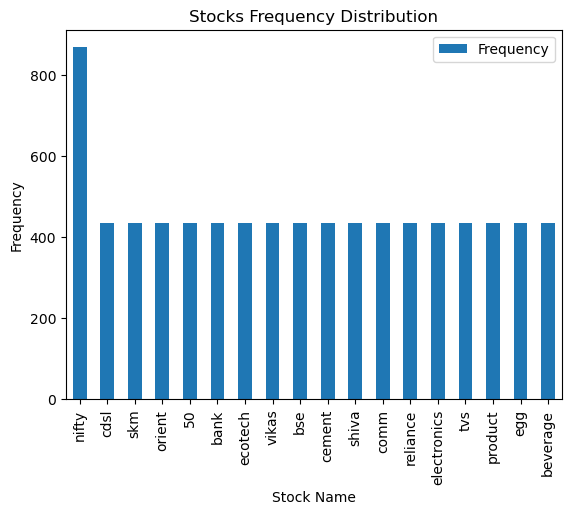

In [3]:
word_freq_df.plot(kind='bar', x='Stock_Name', y='Frequency')
plt.title('Stocks Frequency Distribution')
plt.xlabel('Stock Name')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#Download the df above as csv if needed
word_freq_df.to_csv("frequently_discussed_stocks.csv", index=False)

## 3). Sentiment Analysis
- ### *This is done on the user reviews to understand their notion and ideas behind the stock*
- ### A positive Sentiment Score may determine the bullish nature of stock and vice-versa

In [4]:
import nltk
import matplotlib.pyplot as plt
# Download the VADER lexicon data
nltk.download('vader_lexicon')
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter
import string
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download NLTK datasets (if not already downloaded)
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Load your CSV file into a pandas DataFrame
df = pd.read_csv('moneycontrol_forum_data.csv')

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to preprocess the text and extract relevant words
def preprocess_text(text):
    if isinstance(text, str):  # Check if the text is a string
        text = text.lower()
        text = ''.join([char for char in text if char not in string.punctuation])
        tokens = text.split()
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        return tokens
    else:
        return []  # Return an empty list for non-string values (e.g., NaN)

# Fill missing values in the 'Comments' column with empty strings
df['Comments'].fillna('', inplace=True)

# Apply the preprocessing function to your review column and create a list of all words
all_words = []
for review in df['Comments']:
    words = preprocess_text(review)
    all_words.extend(words)

# Calculate word frequencies using Counter
word_freq = Counter(all_words)

# Convert word frequency analysis results to a DataFrame
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])

# Sort the DataFrame by frequency in descending order
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Perform sentiment analysis on each review and store the sentiment scores in a new column
df['Sentiment'] = df['Comments'].apply(lambda x: sia.polarity_scores(x)['compound'])




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\anee2\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anee2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\anee2\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
df

,Stock,Date,Comments,Sentiment
0,CDSL,schedule10 hours 29 mins ago,this gem should be part of your long term weal...,0.6956
1,SKM Egg Product,schedule10 hours 28 mins ago,"Dont worry.. I am here from 68 levels, just ke...",-0.8876
2,TVS Electronics,schedule10 hours 25 mins ago,maximum and minimum prices for TVS Electronic ...,0.9042
3,Reliance Comm,schedule10 hours 25 mins ago,kyu re tere ko Anil ambani ne bola nahi chaleg...,0.0000
4,Shiva Cement,schedule10 hours 24 mins ago,Expected profit this querter amazing here onwa...,0.9186
...,...,...,...,...
4335,BSE,schedule10 hours 23 mins ago,May touch 1500 in a month then retrace back. T...,0.5512
4336,Vikas Ecotech,schedule10 hours 22 mins ago,people are talking about share price manipulat...,0.7351
4337,Bank Nifty,schedule10 hours 22 mins ago,looking Good after d.option.22.34.886838.me sh...,0.9081
4338,Nifty 50,schedule10 hours 22 mins ago,looking Good after d.option.22.34.886838.me sh...,0.9081


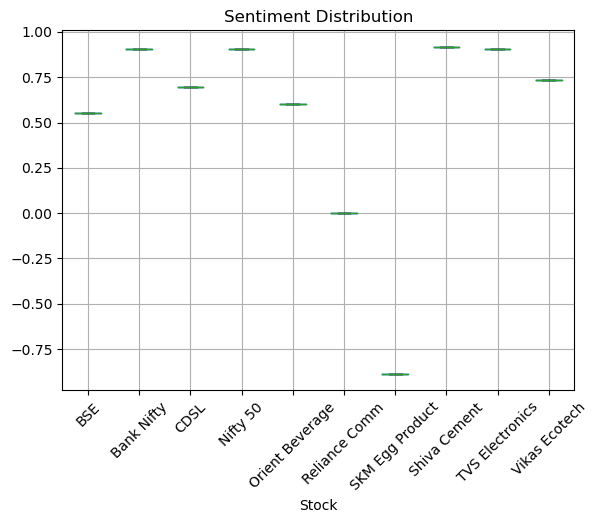

In [6]:
# Create a box plot to visualize sentiment scores of stocks
df.boxplot(column='Sentiment', by='Stock')
plt.title('Sentiment Distribution')
plt.suptitle('')  
plt.xticks(rotation=45)
plt.show()


In [7]:
recommended_stocks = set()
recommended_count = 0
top_recommendations = []

# Iterate through the merged dataframe to recommend products from different brands
for index, row in df.iterrows():
    brand = row['Stock']
    if brand not in recommended_stocks:
        top_recommendations.append(row)
        recommended_stocks.add(brand)
        recommended_count += 1
    if recommended_count >= 10:
        break

# Show the top 10 products based on evaluation score
top_recommendations_df = pd.DataFrame(top_recommendations)
top_recommendations_df

,Stock,Date,Comments,Sentiment
0,CDSL,schedule10 hours 29 mins ago,this gem should be part of your long term weal...,0.6956
1,SKM Egg Product,schedule10 hours 28 mins ago,"Dont worry.. I am here from 68 levels, just ke...",-0.8876
2,TVS Electronics,schedule10 hours 25 mins ago,maximum and minimum prices for TVS Electronic ...,0.9042
3,Reliance Comm,schedule10 hours 25 mins ago,kyu re tere ko Anil ambani ne bola nahi chaleg...,0.0000
4,Shiva Cement,schedule10 hours 24 mins ago,Expected profit this querter amazing here onwa...,0.9186
5,BSE,schedule10 hours 23 mins ago,May touch 1500 in a month then retrace back. T...,0.5512
6,Vikas Ecotech,schedule10 hours 22 mins ago,people are talking about share price manipulat...,0.7351
7,Bank Nifty,schedule10 hours 22 mins ago,looking Good after d.option.22.34.886838.me sh...,0.9081
8,Nifty 50,schedule10 hours 22 mins ago,looking Good after d.option.22.34.886838.me sh...,0.9081
9,Orient Beverage,schedule10 hours 20 mins ago,Madam jayanti chauhanji.bislery is internation...,0.5994


In [9]:
# Display the Stock with sentiment scores
sorted_df = top_recommendations_df[['Stock', 'Sentiment']].sort_values(by='Sentiment', ascending=False)
sorted_df

,Stock,Sentiment
4,Shiva Cement,0.9186
7,Bank Nifty,0.9081
8,Nifty 50,0.9081
2,TVS Electronics,0.9042
6,Vikas Ecotech,0.7351
0,CDSL,0.6956
9,Orient Beverage,0.5994
5,BSE,0.5512
3,Reliance Comm,0.0000
1,SKM Egg Product,-0.8876


## 4). Find ticker names from stock names automatically
- ### *For the Indian stocks, if you have subscription with APIs, use their API key and appropriate code to automatically fetch ticker names for stock names generated above. You can then download the historical data for the particular ticker. Then continue with Step 6 for further predictions.*


## 5). Upload historical data manually
- ### *For the Indian stocks, as there are variations in ticker names, I will be using the free version of Yahoo finance to fetch data for the above recommended stocks.*
- ### Skip this step if you did Step 4 and have the historical data ready.

In [11]:
sorted_df[:3]['Stock']

4    Shiva Cement
7      Bank Nifty
8        Nifty 50
Name: Stock, dtype: object

- #### Let us fetch historical data for Shiva Cement whose ticker name in Yahoo Finance is *SHIVACEM.BO*
- #### User can set the period and dates as per requirement.

[*********************100%%**********************]  1 of 1 completed
Stock data for SHIVACEM.BO:
            Adj Close
Date                 
2018-08-01  23.900000
2018-08-02  23.900000
2018-08-03  23.500000
2018-08-06  24.100000
2018-08-07  23.700001


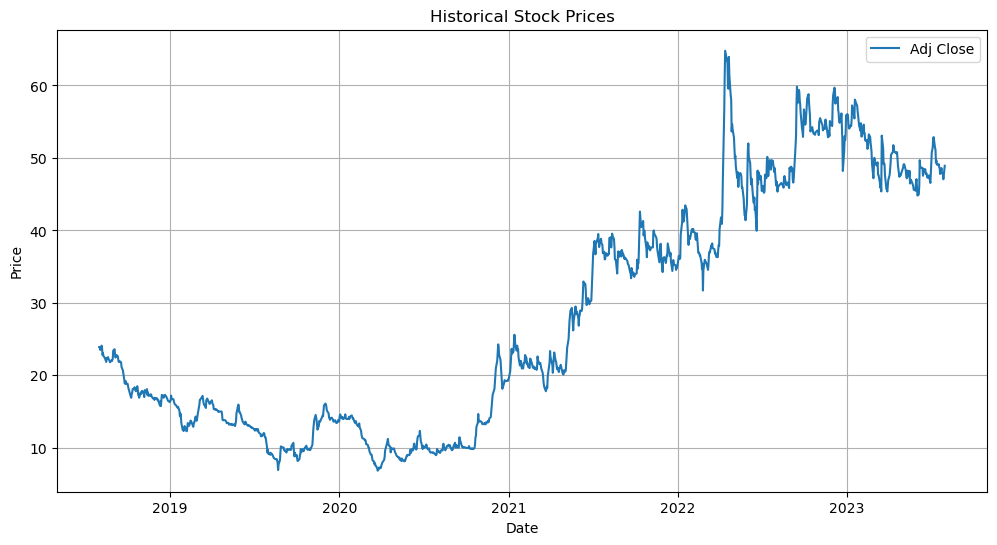

In [50]:
# to download a single csv for portfolio of stocks
# period also mentioned, user can enter the period of download they want
# latest stock price/date on top

import yfinance as yf
import pandas as pd

def get_stock_data(ticker, start_date, end_date, period):
    # Download stock data using yfinance
    data = yf.download(ticker, start=start_date, end=end_date, period=period)
    return data[['Adj Close']]  # Keep only the 'Adj Close' column

def main():
    # Replace the tickers list with the ticker symbols you want to retrieve data for
    tickers = ['SHIVACEM.BO']
    # Replace the start_date and end_date with the desired date range
    start_date = '2018-08-01'
    end_date = '2023-08-01'
    # Choose the data frequency (daily, weekly, monthly, or yearly)
    period = '1d'  # Options: '1d', '1wk', '1mo', '1y'

    all_data = pd.DataFrame()  # Create an empty DataFrame to hold all stock data

    for ticker in tickers:
        # Get stock data for each ticker
        stock_data = get_stock_data(ticker, start_date, end_date, period)

        # Print the first few rows of the data
        print(f"Stock data for {ticker}:")
        print(stock_data.head())

        # Create a copy of the DataFrame to avoid the warning
        stock_data = stock_data.copy()

        # Add the 'Date' column to the stock_data DataFrame
        stock_data['Date'] = stock_data.index

        # Reorder the columns
        stock_data = stock_data[['Date', 'Adj Close']]



        # Append the stock data to the all_data DataFrame
        all_data = pd.concat([all_data, stock_data.set_index('Date')], axis=1)

    # Sort the DataFrame by the index (date) in descending order (latest date on top)
    all_data.sort_index(ascending=False, inplace=True)

        # Plot the historical stock prices
    plt.figure(figsize=(12, 6))
    for column in all_data.columns:
        plt.plot(all_data.index, all_data[column], label=column)

    plt.title('Historical Stock Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


    # Save the sorted data to a CSV file
    all_data.to_csv("historical_data.csv")


if __name__ == "__main__":
    main()


## 6.) LSTM
-  #### We will use the lstm model to predict the stock price given the historical data of the ticker

Epoch 1/10
246/246 [==============================] - 9s 8ms/step - loss: 0.0100
Epoch 2/10
246/246 [==============================] - 2s 8ms/step - loss: 0.0014
Epoch 3/10
246/246 [==============================] - 2s 8ms/step - loss: 0.0012
Epoch 4/10
246/246 [==============================] - 2s 8ms/step - loss: 0.0013
Epoch 5/10
246/246 [==============================] - 2s 7ms/step - loss: 0.0011
Epoch 6/10
246/246 [==============================] - 2s 8ms/step - loss: 0.0012
Epoch 7/10
246/246 [==============================] - 2s 7ms/step - loss: 0.0011
Epoch 8/10
246/246 [==============================] - 2s 7ms/step - loss: 9.7827e-04
Epoch 9/10
246/246 [==============================] - 2s 8ms/step - loss: 0.0010
Epoch 10/10
39/39 [==============================] - 1s 4ms/step


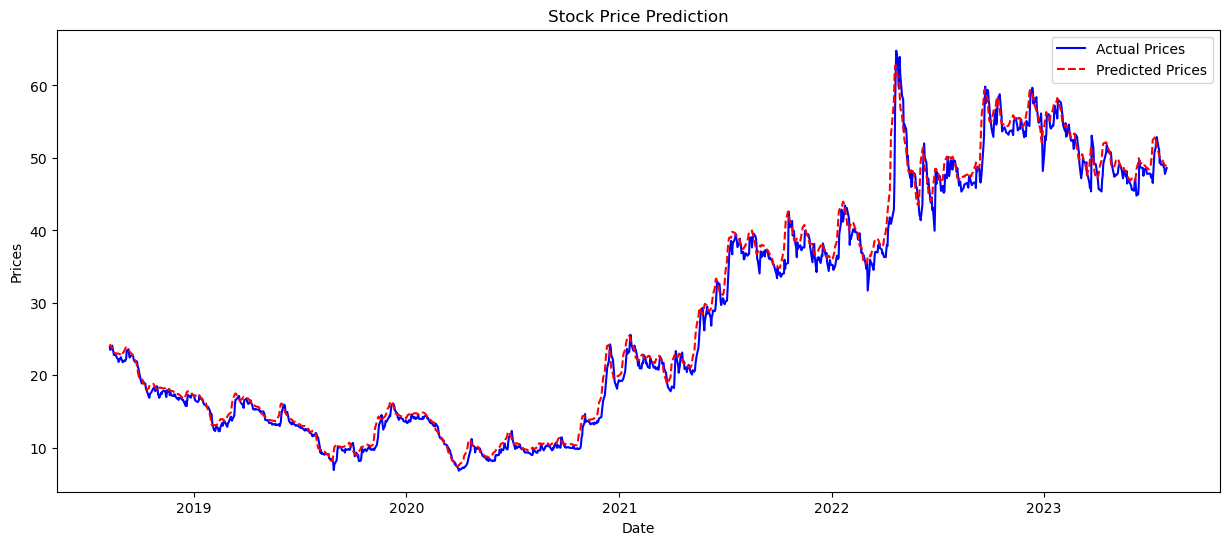

The latest actual stock price is: Rs.48.60
The latest predicted stock price is: Rs.48.90


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#Data Loading
data = pd.read_csv('historical_data.csv')

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
close_prices = data['Adj Close'].values.reshape(-1, 1)

#Normalize data
scaler = MinMaxScaler()
close_prices = scaler.fit_transform(close_prices)

#Generate dataset
look_back = 5
X, y = [], []
for i in range(len(close_prices) - look_back - 1):
    X.append(close_prices[i:(i+look_back), 0])
    y.append(close_prices[i+look_back, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

#Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

#rain model
model.fit(X, y, epochs=10, batch_size=5)

#Predict and visualize 
predicted = model.predict(X)
predicted_prices = scaler.inverse_transform(predicted)


actual_prices = scaler.inverse_transform(y.reshape(-1, 1))

plt.figure(figsize=(15, 6))
plt.plot(data.index[:len(actual_prices)], actual_prices, label='Actual Prices', color='blue')
plt.plot(data.index[:len(actual_prices)], predicted_prices, label='Predicted Prices', color='red', linestyle='dashed')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()


# Convert the NumPy array elements to Python floats
actual_price = float(actual_prices[0])
predicted_price = float(predicted_prices[0])

# Print the latest actual stock price and predicted stock price
print(f"The latest actual stock price is: Rs.{actual_price:.2f}")
print(f"The latest predicted stock price is: Rs.{predicted_price:.2f}")


- ## Here with the LSTM we were able to predict the stock price for the near future.
- ## The predicted price of the stock can be right or wrong and the accuracy of this can only be examined after comparing with its market movements.
